In [1]:
# First we need to read in the required packages and the already defined function
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2,os
import matplotlib.image as mpimg

def DataPreprocess(data_path):
    """
    This function will loop through the data set, preprocess each image
    The input is the path to the data set
    We resize the image to a smaller size to speed up training
    The output will be images and targets in array form
    """
    # Create an empty dictionary to store data
    data_path  = data_path
    categories = ["without_mask", "with_mask"]
    # labels: without_mask, with_mask
    labels = [i for i in range(0, len(categories))]
    # Create an empty dictionary with keys = labels
    label_dict = dict(zip(categories,labels))
    print(label_dict)
    print(categories)
    print(labels)
    # Now loop through the datasets, preprocess each image, 
    # and append the preprocessed image to the empty dictionary created above
    img_size=100
    data=[]
    target=[]
    for category in categories:
        # Construct path to each folder ('without_mask', 'with_mask')
        folder_path=os.path.join(data_path,category)
        img_names=os.listdir(folder_path)
        # Remove ".DS_Store" from the list of image names
        if '.DS_Store' in img_names:
            img_names.remove('.DS_Store')
        # Loop through images in each folder
        for img_name in img_names:
            img_path=os.path.join(folder_path,img_name)
            img=cv2.imread(img_path)
            try:                
                # Resizing the image into 100x100         
                resized=cv2.resize(img,(img_size,img_size))
                # appending the image and the label(categorized) into the list (dataset)
                data.append(resized)
                target.append(label_dict[category])
            except Exception as e:
                print(img_name)
                print('Exception:',e)
                #if any exception rasied, the exception will be printed here.
   
    # now in this part we convert the images and targets into array form, 
    data=np.array(data)
    target=np.array(target)
    return data, target

<h1>§3. Data Augmentation</h1>

Since we want to add some data augmentation layers to our model, we will first experiment wil these layers. 
* First, we will create a tf.keras.layers.RandomFlip() layer. Then plot of the original image versus when RandomFlip() has been applied.

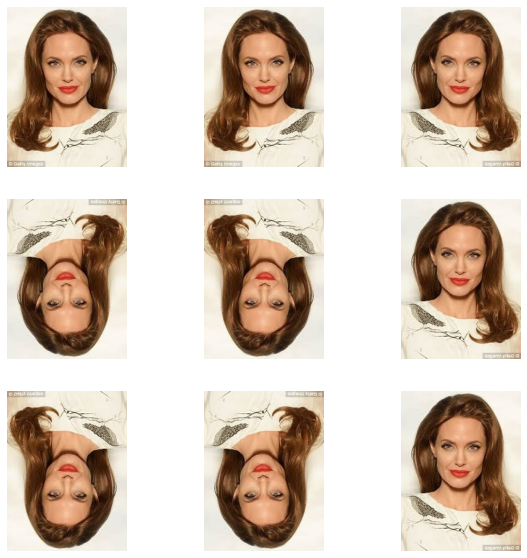

In [44]:
RandomFlip = tf.keras.layers.RandomFlip()
plt.figure(figsize=(10, 10))
image = mpimg.imread("data/without_mask/23.jpg")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = RandomFlip(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

* Then we will create a tf.keras.layers.RandomRotation() layer and make a plot of the original image versus the rotated ones.

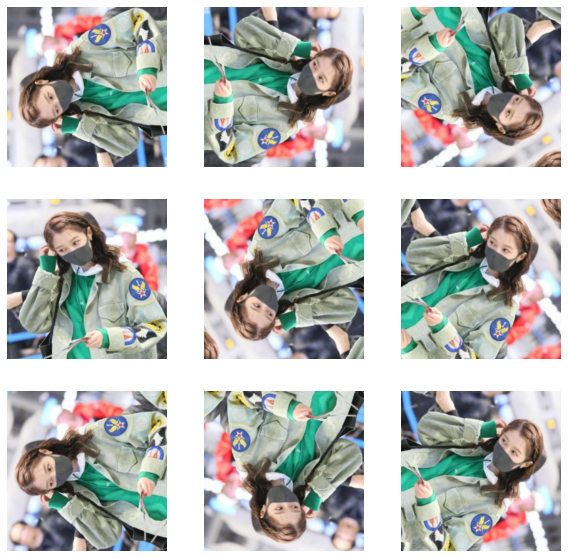

In [45]:
RandomRotation = tf.keras.layers.RandomRotation(0.5)
plt.figure(figsize=(10, 10))
image = mpimg.imread("data/with_mask/000 copy 36.jpg")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = RandomRotation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

<h1>§4. Machine Learning Model</h1>

We will create a tf.keras.Sequential model using both a preprocessor, data augmentation layers, and also some of layers that we have discussed in class

In [69]:
"""
In our model we include:
1. a preprocessor
2. data augmentation: randomly flipping & rotating the images
3. two convolutional 2D layers
4. two max pooling layers
5. two dropout layers to avoid overfitting 
6. a flatten layer
7. and finally two dense layers to match the number of classes in the output
"""
img_size=160
# create a preprocessing layer
i = tf.keras.Input(shape=(img_size, img_size, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

model = tf.keras.Sequential([
    # preprocessing
    preprocessor,
    # data augmentation with flip and rotation
    layers.RandomFlip('horizontal'), 
    layers.RandomRotation(0.05),
    # The first CNN layer is a Convolution layer of a kernel size 3*3
    # It learns the base features and applies'relu' nonlinear transformation.
    # Also specifying the input shape here to be 160
    layers.Conv2D(32, (3,3), activation=layers.LeakyReLU(), input_shape=data.shape[1:]),
    # MaxPooling2D((2, 2)) 2*2 the size of window to find the max
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    # layers.Dropout(0.5),
    # The second convolution layer
    layers.Conv2D(64, (3,3), activation=layers.LeakyReLU()),
    # MaxPooling layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3,3), activation=layers.LeakyReLU()),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3,3), activation=layers.LeakyReLU()),
    # Flatten layer to stack the output convolutions from second convolution layer
    layers.Flatten(),
    # Dense layer of 512 neurons
    layers.Dense(512, activation=layers.LeakyReLU()),    
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [68]:
img_size

160

In [70]:
model.build(data.shape)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_10 (Functional)       (None, 160, 160, 3)       0         
                                                                 
 random_flip_10 (RandomFlip)  (None, 160, 160, 3)      0         
                                                                 
 random_rotation_10 (RandomR  (None, 160, 160, 3)      0         
 otation)                                                        
                                                                 
 conv2d_20 (Conv2D)          (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 79, 79, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 77, 77, 64)       

Now we will train model and plot the history of the accuracy on both the training and validation sets. 

In [71]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# from_logits=True compute softmax when evaluting loss function
# metrics=['accuracy'] want to see how accurate on the data

# fit the model on 80% of the training set, evaluate on the rest
history = model.fit(train_data,
                     train_target, 
                     epochs=20,
                     validation_split=0.2)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
57/57 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.8185WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1544518c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

From the output, we can see that despite that there are some fluctuations in the first few epochs, the validation accuracy of the model stabilizes to a decent leve of well above 90 percent. A visualization of the training history is as follows.

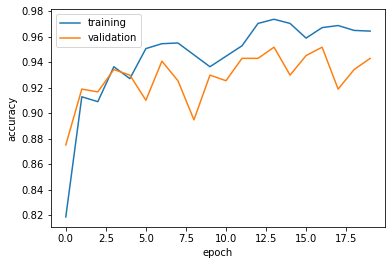

In [72]:
"""
Our results proved to be pretty precise and there
is no apparent sign of overfitting.
"""
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy") # gca: get current axis 
plt.legend()

We see that training accuracy was around 96%, and validation accuracy was around 93-94%. Validation accuracy seems to be a bit unstable. This may be explained by the stochastic nature of the optimization process (i.e., stochastic gradient descent). However, it did stabilize at around 93-94%. 

Now we will evaluate the accuracy of the model on the test dataset

In [31]:
print(model.evaluate(test_data,test_target))

8/8 [==============================] - 1s 146ms/step - loss: 0.1290 - accuracy: 0.9453
[0.1290377378463745, 0.9453125]


The model achieved 95% accuracy on the unseen test dataset. Amazing!

<h1>§5. Testing Model on Data Sets of Different Racial Groups</h1>

* Besides examining the performance on all people comprehensively, we would also like to see if different skin colors and facial characteristics across races might affect the model's performance. 
* We now test our model on Black, White, and Asian people separately to analyze whether our algorithm is biased. We will preprocess each data set and then test our model.

In [73]:
categories = ['without_mask', 'with_mask']

In [84]:
def testing(data_path, model):
    """
    This function will preprocess the data set, test the model on the data set, 
    and create visualization
    """
    # preprocess the data
    data_test, target_test = DataPreprocess(data_path)
    # Test model on the data set
    print(model.evaluate(data_test, target_test))
    # visualize
    y_pred = model.predict(data_test)
    labels_pred = y_pred.argmax(axis = 1)
    plt.figure(figsize=(10,10))
    for i in range(30):
        if i < 15:
            plt.subplot(6,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(data_test[i])
            plt.xlabel(categories[labels_pred[i]])
        else:
            plt.subplot(6,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(data_test[i+25])
            plt.xlabel(categories[labels_pred[i+25]])

#### 1. Data set containing faces of black people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 138ms/step - loss: 0.6066 - accuracy: 0.8475
[0.6065927743911743, 0.8474576473236084]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


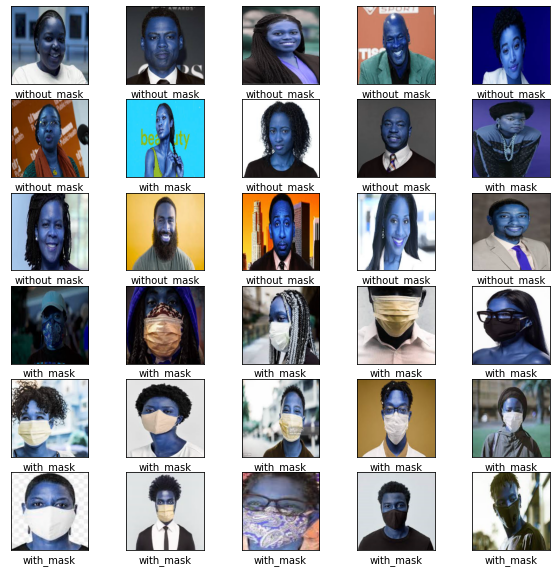

In [75]:
testing("data/Testing_Black", model)

#### 2. Data set containing faces of East Asia people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 145ms/step - loss: 0.6504 - accuracy: 0.8500
[0.6503875255584717, 0.8500000238418579]


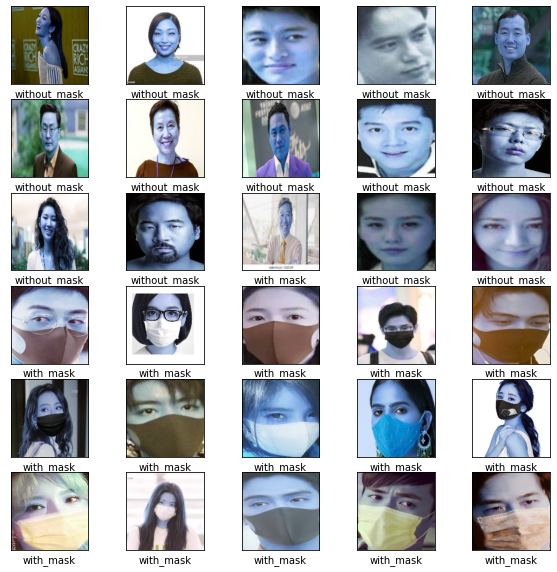

In [79]:
testing("data/Testing_Asian", model)

#### 3. Data set containing faces of White people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 117ms/step - loss: 0.2074 - accuracy: 0.9455
[0.207426980137825, 0.9454545378684998]


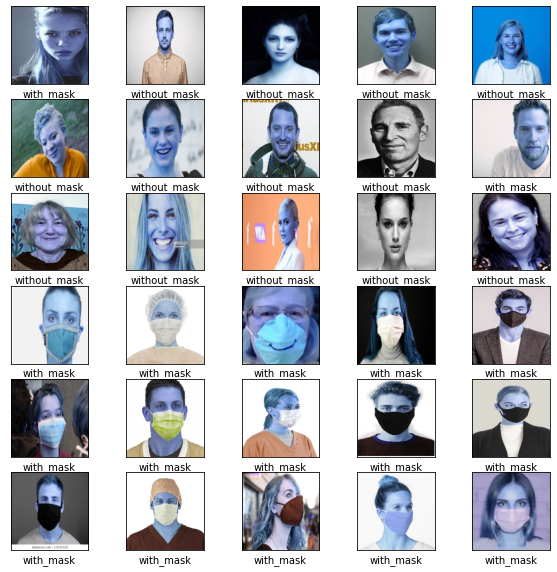

In [78]:
testing("data/Testing_White", model)

We can see that our model performs best on white people with around 95% accuracy. It also shows around 85% accuracy on Asian and black people. The lower accuracy for black people compared to white people might result from a lower percentage of black people's photos in the training dataset. It is interesting that we observed lower accuracy for Asian people as well, even though their images are the most abundant in the training dataset. One reason for this could be that Asian people constitute a pretty heterogeneous group. For example, East Asian and South Asian people look very different from each other. East Asian people are over-represented in our training dataset, whereas others are less so, and the lower prediction accuracy for other Asian subgroups may have contributed to the overall lower accuracy for Asian people.
With these limitations in mind, we believe incorporating more data of black people and other Asian subgroups will help address the racial bias.